Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Episode:     1		score:   13.00		average:   13.00
Episode:     2		score:   25.00		average:   19.00
Episode:     3		score:   37.00		average:   25.00
Episode:     4		score:   57.00		average:   33.00
Episode:     5		score:   16.00		average:   29.60
Episode:     6		score:   32.00		average:   30.00
Episode:     7		score:   13.00		average:   27.57
Episode:     8		score:   14.00		average:   25.88
Episode:     9		score:    9.00		average:   24.00
Episode:    10		score:   33.00		average:   24.90
Episode:    11		score:   79.00		average:   29.82
Episode:    12		score:   16.00		average:   28.67
Episode:    13		score:   11.00		average:   27.31
Episode:    14		score:   18.00		average:   26.64
Episode:    15		score:   33.00		average:   27.07
Episode:    16		score:   13.00		average:   26.19
Episode:    17		score:   62.00		average:   28.29
Episode:    18		score:   22.00		average:   27.94
Episode:    19		score:   22.00		avera

Episode:   161		score:  200.00		average:  163.07
Episode:   162		score:  200.00		average:  164.56
Episode:   163		score:  200.00		average:  164.56
Episode:   164		score:  200.00		average:  165.91
Episode:   165		score:  129.00		average:  165.20
Episode:   166		score:  105.00		average:  164.25
Episode:   167		score:  200.00		average:  164.25
Episode:   168		score:  200.00		average:  164.25
Episode:   169		score:   29.00		average:  162.54
Episode:   170		score:   20.00		average:  160.74
Episode:   171		score:   81.00		average:  159.57
Episode:   172		score:   30.00		average:  159.10
Episode:   173		score:  200.00		average:  159.36
Episode:   174		score:  200.00		average:  161.19
Episode:   175		score:  112.00		average:  161.79
Episode:   176		score:  200.00		average:  162.71
Episode:   177		score:  200.00		average:  162.71
Episode:   178		score:  200.00		average:  164.13
Episode:   179		score:  199.00		average:  165.62
Episode:   180		score:  200.00		average:  166.82
Episode:   181		scor

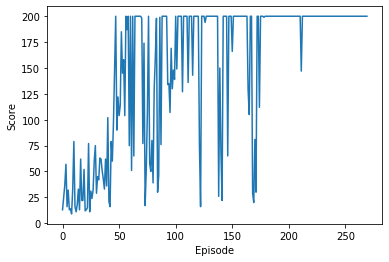

In [1]:
import os

import random
import gym
import pylab
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

#tf.config.experimental_run_functions_eagerly(True)
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import copy

EPISODES = 10000 # Number of times the enviroment is ran
LOSS_CLIPPING = 0.2 # Approximated values stated in the original paper
ENTROPY_LOSS = 0 # Epochs to train the network (recommended between 3 and 30)
LR = 0.02 # Learning rate 
NUM_ACTIONS = 2 # Number of possible action in the environment
NUM_STATES = 4 # Number of possible states in the exvironment
EPOCHS = 10 # Epochs to train the network (recommended between 3 and 30)
BATCH_SIZE = 64 # Batch size for the neural nets
BUFFER_SIZE = 512 # Buffer of experiences
SHUFFLE = True # Whether to shuffle data or not while training
OPTIMIZER = Adam # Optimizer for both actor and critic
GAMMA = 0.99 # Used for the estimated reward
LAMBDA = 0.95 # Used in the original paper un the GAE
NORMALIZE = True # Whether to normalize GAE or not
DUMMY_ACTION, DUMMY_VALUE = np.zeros((1, NUM_ACTIONS)), np.zeros((1, 1)) # Used to feed the actor when predicting


# Custom loss functions for the PPO
def ppo_loss(advantages, actions):
    def loss(y_true, y_pred):
        prob = actions * y_pred
        old_prob = actions * y_true 
        
        ratio = K.exp(K.log(prob + 1e-10) - K.log(old_prob + 1e-10))
        p1 = ratio * advantages
        clip = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 +LOSS_CLIPPING)     
        p2 = clip * advantages
        
        actor_loss = -K.mean(K.minimum(p1, p2))
        
        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy
        
        return total_loss
 
    return loss


# Create the actor used to select the action given an state
class Actor_Model:
    def __init__(self):
        # Define three inputs as the advantage and old prediction is used for the custom loss
        input_state = Input(shape=(NUM_STATES,))
        input_advantage = Input(shape=(1,))
        input_actions = Input(shape=(NUM_ACTIONS,))

        layer1 = Dense(64, activation='relu', kernel_initializer='he_uniform')(input_state)
        layer2 = Dense(64, activation='relu', kernel_initializer='he_uniform')(layer1)

        # Softmax as there are different probabilities depending on the action
        output_layer = Dense(NUM_ACTIONS, activation='softmax', name='output')(layer2)

        self.model = Model(inputs=[input_state, input_advantage, input_actions], outputs=[output_layer])

        # Compile the model with the custom loss
        self.model.compile(optimizer=OPTIMIZER(lr=LR), 
                           loss=[ppo_loss(advantages=input_advantage, actions=input_actions)]) 



# Create the critic which will criticise how the actor is performing    
class Critic_Model:
    def __init__(self):
        X_input = Input(NUM_STATES)

        X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X_input)
        X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
        
        # Linear output to know how good the action is
        value = Dense(1)(X)
        
        # Compile it with mse loss and gradient descent
        self.model = Model(inputs=X_input, outputs = value)
        self.model.compile(loss='mse', optimizer=OPTIMIZER(lr=LR))

# Combine both Actor and Critic to create the agent
class PPOAgent:
    def __init__(self, env_name):
        # Environment parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.episode = 0 # used to track current number episoded since start
        self.max_average = 0 # record max average reached
        
        # Used to plot a grapgh of the train process
        self.scores_, self.average_ = [], []

        # Create Actor-Critic network models
        self.Actor = Actor_Model()
        self.Critic = Critic_Model()
    
        # Names for the models
        self.Actor_name = f"{self.env_name}_PPO_Actor.h5"
        self.Critic_name = f"{self.env_name}_PPO_Critic.h5"

    # Get the action given the current state    
    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.model.predict([state, DUMMY_VALUE, DUMMY_ACTION])[0]
        
        # Probability based to choose the action
        action = np.random.choice(NUM_ACTIONS, p=prediction)
        action_onehot = np.zeros([NUM_ACTIONS])
        action_onehot[action] = 1
        return action, action_onehot, prediction

    # Generalized Advantage Estimation implemented in the original paper
    def get_gaes(self, rewards, dones, values, next_values):
        # Dones are used to track when is the final step of an episode, so next values are no applied
        deltas = [r + GAMMA * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        
        # Convert list to array as .mean() and .std() are used later
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * GAMMA * LAMBDA * gaes[t + 1]

        target = gaes + values
        if NORMALIZE:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # Reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Get Critic network predictions for state and next state
        values = self.Critic.model.predict(states)
        next_values = self.Critic.model.predict(next_states)

        # Get the advantage
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))

        # Stack info to unpack it in the custom loss
        y_true = np.hstack([advantages, predictions, actions])

        # Training Actor and Critic networks
        a_loss = self.Actor.model.fit([states, advantages, actions], predictions, epochs=EPOCHS, 
                                      verbose=0, shuffle=SHUFFLE, batch_size=BATCH_SIZE)
        c_loss = self.Critic.model.fit(states, target, epochs=EPOCHS, verbose=0, shuffle=SHUFFLE, batch_size=BATCH_SIZE)

 
    def load(self):
        self.Actor.Actor.load_weights(self.Actor_name)
        self.Critic.Critic.load_weights(self.Critic_name)

    def save(self):
        self.Actor.model.save_weights(self.Actor_name)
        self.Critic.model.save_weights(self.Critic_name)
        
    def test(self):
        env_name = 'CartPole-v0'       
        env = gym.make(env_name)
        state = env.reset()
        state = np.reshape(state, [1, NUM_STATES])
        score = 0
        scores = []
        done = False
        for ii in range(10):
            while done == False:
                action, _, _ = self.act(state)
                state, reward, done, _ = env.step(action)
                state = np.reshape(state, [1, NUM_STATES])
                score += reward
            done = False
            scores.append(score)
            score = 0
            state = env.reset()
            state = np.reshape(state, [1, NUM_STATES])
        
        env.close()
        scores_step = sum(scores)/10
        return scores_step

    def run_batch(self): # train every self.Training_batch episodes
        start = time.time()
        global LR
        reward_step = []
        state = self.env.reset()
        state = np.reshape(state, [1, NUM_STATES])
        done, score = False, 0
        finished = False
        while finished == False:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            for t in range(BUFFER_SIZE):
                #self.env.render()
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, NUM_STATES]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)
                # Update current state
                state = np.reshape(next_state, [1, NUM_STATES])
                score += reward
                
                if done:
                    self.episode += 1
                    self.scores_.append(score)
                    
                    if self.episode >= 100:
                        average = sum(self.scores_[-100:])/100
                        print('Episode: {:>5}\t\tscore: {:>7.2f}\t\taverage: {:>7.2f}'.format(self.episode, score, average))
                        if average > self.max_average:
                            self.max_average = average
                            
                        if average > 195:
                            plt.plot(self.scores_)
                            plt.xlabel("Episode")
                            plt.ylabel("Score")
                            finished = True
                            break

                    else:
                        print('Episode: {:>5}\t\tscore: {:>7.2f}\t\taverage: {:>7.2f}'.format(self.episode, score, sum(self.scores_)/len(self.scores_)))
                    
                    state, done, score = self.env.reset(), False, 0
                    state = np.reshape(state, [1, NUM_STATES])
            
            #reward_step.append(self.test())
            
            self.replay(states, actions, rewards, predictions, dones, next_states)
            if self.episode >= EPISODES:
                break
        self.env.close()
        print((time.time() - start)/60)
        
                    
if __name__ == "__main__":
    
    env_name = 'CartPole-v0'
    agent = PPOAgent(env_name)
    #agent.run() # train as PPO, train every epesode
    agent.run_batch() # train as PPO, train every batch, trains better
    #agent.run_multiprocesses(num_worker = 8)  # train PPO multiprocessed (fastest)
    #agent.test()
    